### Premium Watch Price Prediction

In [1]:
import os, numpy as np, pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

Oh forgot to import KaggleHub

In [3]:
import kagglehub

In [4]:
df = pd.read_csv(kagglehub.dataset_download("kutayahin/premium-watch-dataset"))
df.head()

100%|██████████| 156k/156k [00:00<00:00, 534kB/s]

Extracting files...


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\Huawei\\.cache\\kagglehub\\datasets\\kutayahin\\premium-watch-dataset\\versions\\1'

Forget it. There is a slighty better yet inefficent (for storage) way to complete this action.

In [6]:
df = pd.read_csv("C:/Users/Huawei/GitHub Repositories/watch-price-prediction/data/raw/samiwatches.csv")
df.head()

,name,MARKA,KOLEKSIYON,price,price_category,CINSIYET,MEKANIZMA,KASA MATERYALI,case_material_category,KASA ÇAPI,...,price_vs_brand_avg,price_percentile,price_zscore,is_price_outlier,collection_popularity,water_resistance_standardized,price_category_improved,case_diameter_numeric,case_size_category,brand_prestige_level
0,Luminor Marina,Panerai,Luminor,473800.0,Luxury,Erkek,Otomatik,Paslanmaz Çelik,Steel,44mm,...,-0.270700,0.797305,0.223958,False,37.0,Yüzme (50m),Lüks,44.0,Büyük (40-44mm),Çok Prestijli
1,Ultra-Chron Classic,Longines,Diving,183000.0,Mid-Range,Erkek,Otomatik,Paslanmaz Çelik,Steel,40mm,...,0.358809,0.517665,-0.302282,False,49.0,Yüzme (50m),Premium,40.0,Orta (36-40mm),Orta Prestij
2,Bvlgari Bvlgari,Bvlgari,Bvlgari Bvlgari,557000.0,Ultra-Luxury,Kadın,Pilli,Altın,Gold,26mm,...,0.083490,0.844611,0.374520,False,14.0,Günlük Kullanım (30m),Lüks,26.0,Küçük (<36mm),Çok Prestijli
3,Specialities Paris 2024 Bronze Gold Edition,Omega,Diğer Koleksiyonlar,611100.0,Ultra-Luxury,Erkek,Elle Kurmalı,Altın,Gold,39mm,...,0.190009,0.862874,0.472421,False,1.0,Günlük Kullanım (30m),Lüks,39.0,Orta (36-40mm),Çok Prestijli
4,Pioneer Centre Seconds Spiced Aqua,H. Moser & Cie.,Pioneer,858000.0,Ultra-Luxury,Erkek,Otomatik,Paslanmak Çelik DLC,Steel,42.8mm,...,-0.620544,0.917365,0.919219,False,7.0,Diğer,Ultra Lüks,42.8,Büyük (40-44mm),Ultra Prestijli


In [8]:
print("Shape is:", df.shape)
print("\nColumns are like:\n", df.columns.tolist())

print("\nInfo:")
print(df.info())

Shape is: (1670, 42)

Columns are like:
 ['name', 'MARKA', 'KOLEKSIYON', 'price', 'price_category', 'CINSIYET', 'MEKANIZMA', 'KASA MATERYALI', 'case_material_category', 'KASA ÇAPI', 'SU REZISTANSI', 'water_resistance_category', 'brand_country', 'brand_age', 'collection_price_tier', 'url', 'image', 'page', 'scraped_at', 'AILE', 'GARANTI SÜRESI', 'GÜÇ REZERVI', 'KADRAN', 'KAYIŞ', 'PRODUCT_NAME_DETAIL', 'PRODUCT_PRICE_DETAIL', 'REFERANS', 'brand_founded_year', 'brand_avg_price', 'brand_median_price', 'brand_price_std', 'brand_product_count', 'price_vs_brand_avg', 'price_percentile', 'price_zscore', 'is_price_outlier', 'collection_popularity', 'water_resistance_standardized', 'price_category_improved', 'case_diameter_numeric', 'case_size_category', 'brand_prestige_level']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670 entries, 0 to 1669
Data columns (total 42 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         -----------

Summarisation of the statistics of the dataset

In [9]:
display(df.describe(include='all'))

,name,MARKA,KOLEKSIYON,price,price_category,CINSIYET,MEKANIZMA,KASA MATERYALI,case_material_category,KASA ÇAPI,...,price_vs_brand_avg,price_percentile,price_zscore,is_price_outlier,collection_popularity,water_resistance_standardized,price_category_improved,case_diameter_numeric,case_size_category,brand_prestige_level
count,1670,1670,1670,1.670000e+03,1670,1670,1670,1670,1670,1670,...,1.670000e+03,1670.000000,1.670000e+03,1670,1670.000000,1670,1670,1670.000000,1670,1670
unique,581,22,77,NaN,4,3,3,13,6,61,...,NaN,NaN,NaN,2,NaN,7,5,NaN,4,5
top,Conquest,Tissot,T-Classic Collection,NaN,Mid-Range,Erkek,Otomatik,Paslanmaz Çelik,Steel,42mm,...,NaN,NaN,NaN,False,NaN,Snorkeling (100m),Orta Segment,NaN,Büyük (40-44mm),Orta Prestij
freq,44,288,160,NaN,636,1129,1122,1219,1220,262,...,NaN,NaN,NaN,1613,NaN,551,423,NaN,629,537
mean,NaN,NaN,NaN,3.500409e+05,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.762275e-10,0.500299,-1.969299e-09,NaN,47.510180,NaN,NaN,38.927455,NaN,NaN
std,NaN,NaN,NaN,5.525988e+05,NaN,NaN,NaN,NaN,NaN,NaN,...,5.529717e-01,0.288760,1.000000e+00,NaN,43.323434,NaN,NaN,5.463735,NaN,NaN
min,NaN,NaN,NaN,1.380000e+04,NaN,NaN,NaN,NaN,NaN,NaN,...,-7.121067e-01,0.000898,-6.084720e-01,NaN,1.000000,NaN,NaN,19.500000,NaN,NaN
25%,NaN,NaN,NaN,9.100000e+04,NaN,NaN,NaN,NaN,NaN,NaN,...,-3.425840e-01,0.250599,-4.687685e-01,NaN,17.000000,NaN,NaN,36.000000,NaN,NaN
50%,NaN,NaN,NaN,1.742000e+05,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.331544e-01,0.502395,-3.182071e-01,NaN,37.000000,NaN,NaN,40.000000,NaN,NaN
75%,NaN,NaN,NaN,4.066000e+05,NaN,NaN,NaN,NaN,NaN,NaN,...,2.176764e-01,0.750150,1.023511e-01,NaN,57.000000,NaN,NaN,42.000000,NaN,NaN


In [10]:
PRICE_COL = "price"

if PRICE_COL in df.columns:
    print("\nPrice summary:")
    display(df[PRICE_COL].describe())
else:
    raise ValueError("Please update PRICE_COL to match the dataset.")


Price summary:


count    1.670000e+03
mean     3.500409e+05
std      5.525988e+05
min      1.380000e+04
25%      9.100000e+04
50%      1.742000e+05
75%      4.066000e+05
max      7.321600e+06
Name: price, dtype: float64

Exploratory Data Analysis

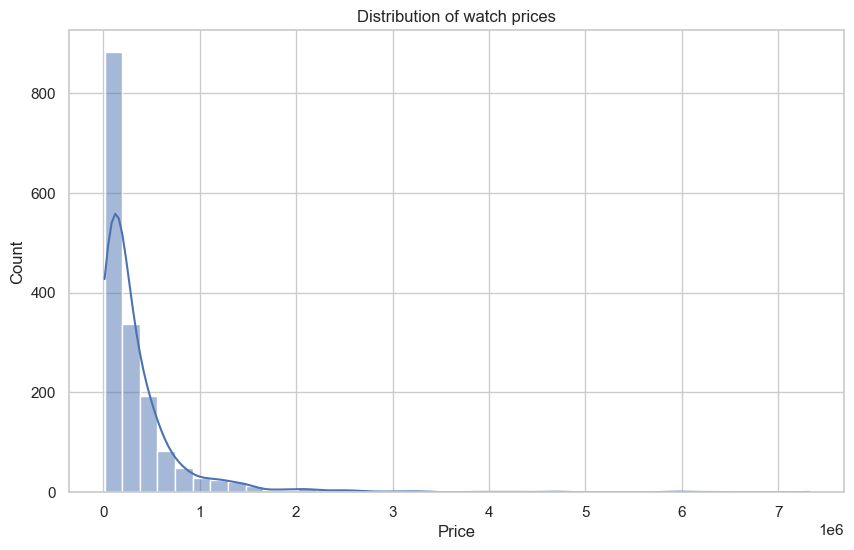

AILE                  973
GÜÇ REZERVI           493
brand_founded_year    417
brand_age             417
GARANTI SÜRESI          5
brand_price_std         2
SU REZISTANSI           1
dtype: int64

In [11]:
sns.histplot(df[PRICE_COL], bins=40, kde=True)
plt.title("Distribution of watch prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]


What are the categorical features anyway?

In [12]:
candidate_cats = [
    "MARKA",
    "KOLEKSIYON",      # e.g. model line
    "MEKANIZMA",        # automatic/quartz/mechanical
    "KASA MATERYALI",
    "BİLEZİK MATERYALİ",
    "CINSIYET",          #
]

for col in candidate_cats:
    if col in df.columns:
        print(f"\nValue counts for {col}:")
        print(df[col].value_counts().head(10))


Value counts for MARKA:
MARKA
Tissot             288
Longines           267
Omega              140
Tag Heuer          133
Breitling          125
Baume & Mercier     96
Rado                95
Hublot              92
Panerai             89
Oris                79
Name: count, dtype: int64

Value counts for KOLEKSIYON:
KOLEKSIYON
T-Classic Collection     160
T-Sport Collection        97
Elegance                  69
Seamaster                 59
Performance               57
Watchmaking Tradition     54
Aquaracer                 50
Diving                    49
Riviera                   45
Classic Fusion            45
Name: count, dtype: int64

Value counts for MEKANIZMA:
MEKANIZMA
Otomatik        1122
Pilli            488
Elle Kurmalı      60
Name: count, dtype: int64

Value counts for KASA MATERYALI:
KASA MATERYALI
Paslanmaz Çelik    1219
Çelik Altın         143
Titanyum            104
Seramik              85
Pembe Altın          51
Karbon               26
Altın                19
Alüminyum  

In [13]:
if PRICE_COL not in df.columns:
    raise ValueError(f"{PRICE_COL} is not a column in the dataframe")

In [14]:
drop_cols = [
    col for col in [
        PRICE_COL,
        "url",
        "product_id",
        "reference_number",
        "description",
    ]
    if col in df.columns
]

In [15]:
feature_cols = [c for c in df.columns if c not in drop_cols]

print("Number of feature columns:", len(feature_cols))
feature_cols

Number of feature columns: 40


['name',
 'MARKA',
 'KOLEKSIYON',
 'price_category',
 'CINSIYET',
 'MEKANIZMA',
 'KASA MATERYALI',
 'case_material_category',
 'KASA ÇAPI',
 'SU REZISTANSI',
 'water_resistance_category',
 'brand_country',
 'brand_age',
 'collection_price_tier',
 'image',
 'page',
 'scraped_at',
 'AILE',
 'GARANTI SÜRESI',
 'GÜÇ REZERVI',
 'KADRAN',
 'KAYIŞ',
 'PRODUCT_NAME_DETAIL',
 'PRODUCT_PRICE_DETAIL',
 'REFERANS',
 'brand_founded_year',
 'brand_avg_price',
 'brand_median_price',
 'brand_price_std',
 'brand_product_count',
 'price_vs_brand_avg',
 'price_percentile',
 'price_zscore',
 'is_price_outlier',
 'collection_popularity',
 'water_resistance_standardized',
 'price_category_improved',
 'case_diameter_numeric',
 'case_size_category',
 'brand_prestige_level']

In [16]:
numeric_features = []
categorical_features = []

for col in feature_cols:
    if pd.api.types.is_numeric_dtype(df[col]):
        numeric_features.append(col)
    else:
        categorical_features.append(col)

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

Numeric features: ['brand_age', 'page', 'brand_founded_year', 'brand_avg_price', 'brand_median_price', 'brand_price_std', 'brand_product_count', 'price_vs_brand_avg', 'price_percentile', 'price_zscore', 'is_price_outlier', 'collection_popularity', 'case_diameter_numeric']
Categorical features: ['name', 'MARKA', 'KOLEKSIYON', 'price_category', 'CINSIYET', 'MEKANIZMA', 'KASA MATERYALI', 'case_material_category', 'KASA ÇAPI', 'SU REZISTANSI', 'water_resistance_category', 'brand_country', 'collection_price_tier', 'image', 'scraped_at', 'AILE', 'GARANTI SÜRESI', 'GÜÇ REZERVI', 'KADRAN', 'KAYIŞ', 'PRODUCT_NAME_DETAIL', 'PRODUCT_PRICE_DETAIL', 'REFERANS', 'water_resistance_standardized', 'price_category_improved', 'case_size_category', 'brand_prestige_level']


In [17]:
X = df[feature_cols].copy()
y = df[PRICE_COL].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape


((1336, 40), (334, 40))

In [18]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [19]:
linreg_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

linreg_pipe.fit(X_train, y_train)

y_pred_lr = linreg_pipe.predict(X_test)

def regression_metrics(y_true, y_pred, label="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} performance:")
    print(f"  MAE  : {mae:,.2f}")
    print(f"  RMSE : {rmse:,.2f}")
    print(f"  R²   : {r2:.3f}")
    print("-" * 40)

regression_metrics(y_test, y_pred_lr, label="Linear Regression")

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Interesting, linear regression is not doing well. Or maybe our column is not linearly related to price.

Let's try something in order to make it more linear, or directly to fix it.

In [20]:
before_rows = df.shape[0]
df = df.dropna(subset=[PRICE_COL])
after_rows = df.shape[0]

print(f"Dropped {before_rows - after_rows} rows with missing target '{PRICE_COL}'.")


Dropped 0 rows with missing target 'price'.


In [21]:
missing_per_col = df.isna().sum().sort_values(ascending=False)
missing_per_col[missing_per_col > 0]

AILE                  973
GÜÇ REZERVI           493
brand_founded_year    417
brand_age             417
GARANTI SÜRESI          5
brand_price_std         2
SU REZISTANSI           1
dtype: int64

In [22]:
drop_cols = [
    PRICE_COL,
    "url",
    "product_id",
    "reference_number",
    "description",
]

feature_cols = [c for c in df.columns if c not in drop_cols]

numeric_features = []
categorical_features = []

for col in feature_cols:
    if pd.api.types.is_numeric_dtype(df[col]):
        numeric_features.append(col)
    else:
        categorical_features.append(col)

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['brand_age', 'page', 'brand_founded_year', 'brand_avg_price', 'brand_median_price', 'brand_price_std', 'brand_product_count', 'price_vs_brand_avg', 'price_percentile', 'price_zscore', 'is_price_outlier', 'collection_popularity', 'case_diameter_numeric']
Categorical features: ['name', 'MARKA', 'KOLEKSIYON', 'price_category', 'CINSIYET', 'MEKANIZMA', 'KASA MATERYALI', 'case_material_category', 'KASA ÇAPI', 'SU REZISTANSI', 'water_resistance_category', 'brand_country', 'collection_price_tier', 'image', 'scraped_at', 'AILE', 'GARANTI SÜRESI', 'GÜÇ REZERVI', 'KADRAN', 'KAYIŞ', 'PRODUCT_NAME_DETAIL', 'PRODUCT_PRICE_DETAIL', 'REFERANS', 'water_resistance_standardized', 'price_category_improved', 'case_size_category', 'brand_prestige_level']


We have:
- assured that the target column does **not** contain any NaN;
- saw that some columns like `AILE`, `GÜÇ REZERVI` and others have some missing values;
- rebuilt `feature_cols`, `numeric_features`, `categorical_features`.

Since they are not properly working and insufficient, then the only way remains is:

## ADDING IMPUTERS 👽

In [23]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # NEW
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # NEW
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


I got tired but let's go on.

In [24]:
X = df[feature_cols].copy()
y = df[PRICE_COL].copy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((1336, 40), (334, 40))

Fitting `LinRegressor` again

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

linreg_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

linreg_pipe.fit(X_train, y_train)

y_pred_lr = linreg_pipe.predict(X_test)

def regression_metrics(y_true, y_pred, label="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} performance:")
    print(f"  MAE  : {mae:,.2f}")
    print(f"  RMSE : {rmse:,.2f}")
    print(f"  R²   : {r2:.3f}")
    print("-" * 40)

regression_metrics(y_test, y_pred_lr, label="Linear Regression")


Linear Regression performance:
  MAE  : 3,045.71
  RMSE : 105,765,845.37
  R²   : 1.000
----------------------------------------


In [27]:
rf_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)

regression_metrics(y_test, y_pred_rf, label="Random Forest")


Random Forest performance:
  MAE  : 8,427.45
  RMSE : 9,892,611,896.42
  R²   : 0.976
----------------------------------------


In [28]:
param_distributions = {
    "model__n_estimators": [200, 300, 500, 800],
    "model__max_depth": [None, 5, 10, 15, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
}

rf_base = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=200,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

random_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_distributions,
    n_iter=20,
    scoring="neg_root_mean_squared_error",
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best CV RMSE:", -random_search.best_score_)

best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)
regression_metrics(y_test, y_pred_best, label="Tuned Random Forest")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'model__n_estimators': 800, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': None}
Best CV RMSE: 58782.73068643001
Tuned Random Forest performance:
  MAE  : 8,471.00
  RMSE : 10,907,290,088.56
  R²   : 0.974
----------------------------------------


Feature Importance from RF

In [29]:
onehot = best_model.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
ohe_feature_names = onehot.get_feature_names_out(categorical_features)

all_feature_names = numeric_features + list(ohe_feature_names)

rf = best_model.named_steps["model"]
importances = rf.feature_importances_

feature_importances = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

feature_importances.head(20)


,feature,importance
9,price_zscore,0.513549
8,price_percentile,0.478901
10,is_price_outlier,0.002351
619,price_category_Ultra-Luxury,0.001119
7,price_vs_brand_avg,0.000771
4483,PRODUCT_PRICE_DETAIL_5.928.000₺,0.000536
3961,PRODUCT_NAME_DETAIL_Streamliner Tourbillon,0.000491
453,name_Streamliner Tourbillon,0.000315
3505,KADRAN_İskelet,0.000296
1,page,0.000271


Now plotting top 20

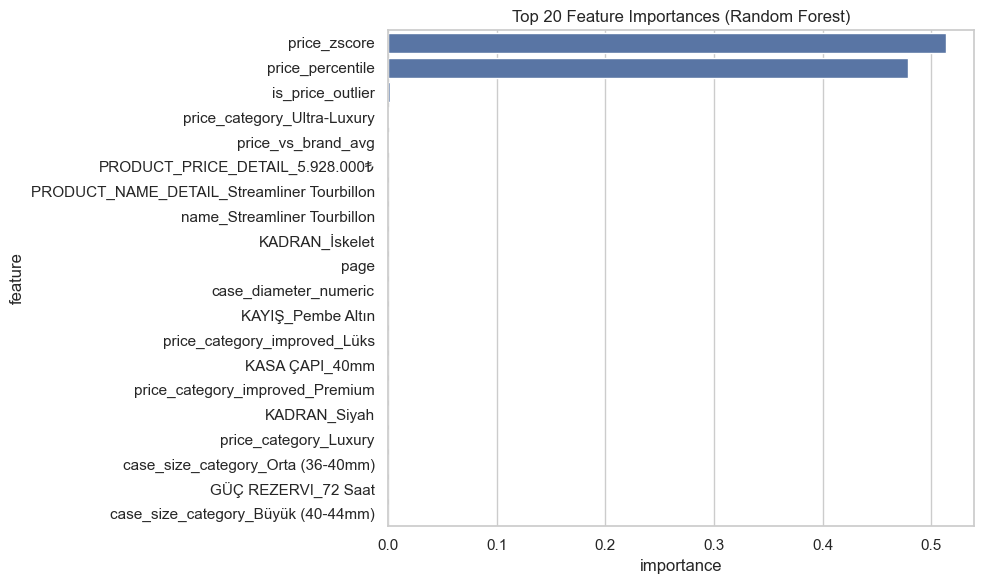

In [31]:
top_n = 20
sns.barplot(
    data=feature_importances.head(top_n),
    x="importance",
    y="feature"
)
plt.title(f"Top {top_n} Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


This kinda gives us ```what drives price?``` section

Now the last step: saving model and preprocessor for future API/ app deployment

In [32]:
import joblib

os.makedirs("models", exist_ok=True)
model_path = "models/best_random_forest_watch_price.pkl"

joblib.dump(best_model, model_path)
print(f"Saved model to {model_path}")


Saved model to models/best_random_forest_watch_price.pkl


How about a simple prediction interface for manual testing?

In [37]:
example_watch = {
    "MARKA": "Rolex",
    "KOLEKSIYON": "Submariner",
    "CINSIYET": "Erkek",
    "MEKANIZMA": "Otomatik",
    "KASA MATERYALI": "Çelik",
    "case_material_category": "Çelik",
    "KASA ÇAPI": 41,
    "case_diameter_numeric": 41,
    "SU REZISTANSI": 100,
    "water_resistance_category": "100 m",
    "KAYIŞ": "Çelik",
}

example_df = pd.DataFrame([example_watch])

for col in feature_cols:
    if col not in example_df.columns:
        if pd.api.types.is_numeric_dtype(X_train[col]):
            example_df[col] = X_train[col].median()
        else:
            example_df[col] = X_train[col].mode()[0]

example_df = example_df[feature_cols]

predicted_price = best_model.predict(example_df)[0]
print(f"Predicted price for this configuration: {predicted_price:,.2f}")


Predicted price for this configuration: 173,223.70


Hm, not bad.

EVEN THOUGH IT CAN'T AFFORD THE OMNITRIX!

![](https://initiate.alphacoders.com/content_requests/1523615.jpg)

Oh btw thank you!